# Natural Gas Predictor
## This notebook is designed to give some more insight to given data and try to train neural network with chosen attributes

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from math import ceil, floor
import numpy as np
from sklearn.model_selection import train_test_split

FILE_URL = 'https://www.eia.gov/opendata/bulk/NG.zip'
SPOT_PRICE_DAILY_ID = 'NG.RNGWHHD.D'
MAIN_STORAGE_ID = 'NG.NW2_EPG0_SWO_R48_BCF.W'
# NG.N5020US2.M - Total U.S. Natural Gas Storage Monthly. Can be incorporated later to enhance the model.
ALL_IDS = [SPOT_PRICE_DAILY_ID,
           'NG.NW2_EPG0_SWO_R48_BCF.W', 'NG.N9070US2.M', 'NG.N9140US1.M', 'NG.N9130US2.M']

## Download latest version of natural gas info file and unzip it

In [3]:
import urllib.request

_ = urllib.request.urlretrieve(FILE_URL, "NG.zip")

In [4]:
from zipfile import ZipFile
  
with ZipFile("NG.zip", 'r') as nat_gas_zipped:
    nat_gas_zipped.extractall()

## Open the file and drop rows without data


In [5]:
with open("NG.txt", "r") as f:
    df = pd.read_json(f, lines=True)

In [6]:
df = df[df['data'].notna()]

In [7]:
df.columns

Index(['series_id', 'name', 'units', 'f', 'unitsshort', 'description',
       'copyright', 'source', 'start', 'end', 'last_updated', 'data',
       'iso3166', 'geography', 'geography2', 'category_id',
       'parent_category_id', 'notes', 'childseries'],
      dtype='object')

### Load Futures Prices

In [8]:
def read_csv_autoencoding(path):
    for enc in ['utf-8', 'utf-8-sig', 'latin1', 'cp1250']:
        try:
            df = pd.read_csv(path, encoding=enc)
            print(f"✅ Loaded {path} using {enc}")
            return df
        except Exception as e:
            continue
    raise ValueError(f"❌ Could not read {path} with common encodings")

# --- Wczytanie trzech plików ---
futures = read_csv_autoencoding("NewData/Natural Gas Futures Historical Data.csv")

# --- Normalizacja nazw kolumn ---
futures.rename(columns={c: f"Futures {c}" for c in futures.columns if c != "Date"}, inplace=True)
futures.rename(columns={"Date": "date"}, inplace=True)

# --- Konwersja dat ---
futures["date"] = pd.to_datetime(futures["date"], errors="coerce")

# # --- Połączenie wg daty ---
# merged = pd.merge(futures, spot, on="date", how="outer")

# # --- Sortowanie wg daty ---
# merged.sort_values("date", inplace=True)

# print(merged.tail())

# # --- Zapis do CSV w poprawnym kodowaniu (UTF-8 z BOM, dla Excel) ---
# merged.to_csv("merged_gas_data.csv", index=False, encoding="utf-8-sig")

✅ Loaded NewData/Natural Gas Futures Historical Data.csv using utf-8


## Show series which are related to interesting data


In [9]:
def read_row_of_data(row_name=None, row_id=None, series_name=None):
    if row_name:
        row_filter = df['name'] == row_name
    elif row_id:
        row_filter = df['series_id'] == row_id
        row_name = df[row_filter]['name'].to_list()[0]
    data = df[row_filter]['data'].to_list()
    try:
        observation_dates = [datetime.datetime.strptime(
            el[0], '%Y%m%d').date() for el in data[0]]
    except ValueError as e:
        try:
            observation_dates = [datetime.datetime.strptime(
                el[0], '%Y%m').date() for el in data[0]]
        except ValueError as e:
            observation_dates = [datetime.datetime.strptime(
                el[0], '%Y').date() for el in data[0]]
    return pd.Series(
        data=[el[1] for el in data[0]], index=pd.DatetimeIndex(observation_dates), name=row_name)

### Looking for production Data

In [10]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
    display(df[(df['name'].str.contains('U.S.')) & (df['name'].str.contains(
        'Production')) & (df['f'].isin(['D', 'W', 'M']))][['name', 'series_id']])

,name,series_id
744,"U.S. Natural Gas Plant Liquids Production, Gaseous Equivalent, Monthly",NG.N9060US1.M
778,"U.S. Natural Gas Plant Liquids Production, Monthly",NG.N9060US2.M
779,"U.S. Dry Natural Gas Production, Monthly",NG.N9070US1.M
780,"U.S. Dry Natural Gas Production, Monthly",NG.N9070US2.M
1207,"U.S. Natural Gas Marketed Production, Monthly",NG.N9050US2.M
1630,"U.S. Natural Gas Marketed Production (Wet), Monthly",NG.N9050US1.M


### Checking duplicate series for storage

In [11]:
series_to_check = ['NG.N5020US2.M', MAIN_STORAGE_ID]

data_to_plot = pd.concat([read_row_of_data(row_id=series_id) for series_id in series_to_check], axis=1, join='outer')
data_to_plot.tail(15)

,"U.S. Total Natural Gas in Underground Storage (Working Gas), Monthly","Weekly Lower 48 States Natural Gas Working Underground Storage, Weekly"
2025-08-01,3328548.0,3130.0
2025-08-08,NaN,3186.0
2025-08-15,NaN,3199.0
2025-08-22,NaN,3217.0
2025-08-29,NaN,3272.0
2025-09-05,NaN,3343.0
2025-09-12,NaN,3433.0
2025-09-19,NaN,3508.0
2025-09-26,NaN,3561.0
2025-10-03,NaN,3641.0


### Saving series names, description and code to file to digest it with use of Chat GPT

In [12]:
columns = df.columns.to_list()
columns.remove('data')
df[columns].to_csv('NG_series_metadata.csv', index=False)

### Merging all possible data and exploring

In [13]:
all_data_list = []
for name in df['name']:
    data_for_series = read_row_of_data(row_name=name)
    if data_for_series.index.has_duplicates:
        print("Duplicates in element name: ", getattr(data_for_series, "name", None))
        print(data_for_series.index[data_for_series.index.duplicated()])
        print("Skipping...")
        continue
    all_data_list.append(data_for_series)
all_data_df = pd.concat(all_data_list, axis=1, join='outer')
# Remove futures as they will be added from different file
all_data_df = all_data_df[[col for col in all_data_df.columns if "Futures" not in col]]

Duplicates in element name:  U.S. Natural Gas Rotary Rigs in Operation, Monthly
DatetimeIndex(['2025-04-01'], dtype='datetime64[ns]', freq=None)
Skipping...
Duplicates in element name:  U.S. Crude Oil Rotary Rigs in Operation, Monthly
DatetimeIndex(['2025-04-01'], dtype='datetime64[ns]', freq=None)
Skipping...
Duplicates in element name:  U.S. Crude Oil and Natural Gas Rotary Rigs in Operation, Annual
DatetimeIndex(['2023-01-01'], dtype='datetime64[ns]', freq=None)
Skipping...
Duplicates in element name:  U.S. Natural Gas Rotary Rigs in Operation, Annual
DatetimeIndex(['2023-01-01'], dtype='datetime64[ns]', freq=None)
Skipping...
Duplicates in element name:  U.S. Onshore Crude Oil and Natural Gas Rotary Rigs in Operation, Annual
DatetimeIndex(['2023-01-01'], dtype='datetime64[ns]', freq=None)
Skipping...
Duplicates in element name:  U.S. Crude Oil Rotary Rigs in Operation, Annual
DatetimeIndex(['2023-01-01'], dtype='datetime64[ns]', freq=None)
Skipping...


In [14]:
all_data_df = pd.concat([all_data_df, futures.set_index('date')], axis=1, join='outer')

In [15]:
all_data_df = all_data_df.sort_index()
all_data_df = all_data_df.fillna(method='ffill')
all_data_df = all_data_df.loc[:, ~
                                     all_data_df.columns.duplicated()].copy()
all_data_df = all_data_df[~all_data_df[['Henry Hub Natural Gas Spot Price, Daily', 'Futures Price', 'Weekly Lower 48 States Natural Gas Working Underground Storage, Weekly']].isna().any(axis=1)]

In [16]:
len(all_data_df.columns)

15564

In [17]:
print([col for col in all_data_df.columns if "Futures" in col])

['Futures Price', 'Futures Open', 'Futures High', 'Futures Low', 'Futures Vol.', 'Futures Change %']


In [18]:
all_data_df['Futures Price'].dtype

dtype('float64')

In [19]:
num_df = all_data_df.apply(pd.to_numeric, errors='coerce')
correlations_df = num_df.corrwith(other=num_df['Futures Price'])

In [20]:
# show series that has strong correlation with price of natural gas

with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
    display(correlations_df.loc[(~correlations_df.index.str.contains('price')) & (~correlations_df.index.str.contains('Price')) & (~correlations_df.index.str.contains('Annual')) & ((correlations_df >= 0.7) | (correlations_df <= -0.7))])

Del Rio, TX Natural Gas Pipeline Exports to Mexico, Monthly                 0.883785
Corpus Christi, TX Liquefied Natural Gas Exports to Panama, Monthly        -0.714612
Galvan Ranch, TX Natural Gas Pipeline Imports From Mexico, Monthly          0.899711
Niagara Falls, NY Natural Gas Pipeline Exports to Canada, Monthly           0.813130
Port of Morgan, MT Natural Gas Pipeline Imports From Canada, Monthly        0.809627
St. Clair, MI Natural Gas Pipeline Exports to Canada, Monthly               0.838778
Noyes, MN Natural Gas Pipeline Imports From Canada, Monthly                 0.770253
McAllen, TX Natural Gas Pipeline Exports to Mexico, Monthly                 0.714388
Detroit, MI Natural Gas Pipeline Exports to Canada, Monthly                 0.870468
Jacksonville, FL Liquefied Natural Gas Exports to All Countries, Monthly    0.713923
Marysville, MI Natural Gas Pipeline Exports to Canada, Monthly              0.765454
Sweetgrass, MT Liquefied Natural Gas Imports from Canada, Monthly

As you can see there are not too much Series with very strong (over 0.7 or under -0.7) correlation with NG price. Exports and imports to various countries are irrelevant because they are aggregated in total import/export series

## Plot data about daily prices during a year


In [21]:
price_df = all_data_df[['Henry Hub Natural Gas Spot Price, Daily', 'Futures Price']]
now_datetime = datetime.datetime.now()

In [22]:
grouped_price_df = price_df.groupby(price_df.index.year)

In [23]:
def get_prices_for_year(df, column, year):
    dr = pd.date_range(datetime.datetime(2000, 1, 1),
                       datetime.datetime(2000, 12, 31))
    curr_group = df.get_group(year)
    new_list = []
    for date in dr:
        query = curr_group[(curr_group.index.month == date.month) & (
            curr_group.index.day == date.day)]
        new_list.append(None if query.empty else query.iloc[0][column])
    return pd.Series(new_list, index=dr, name=year).dropna()

## Plot for seasonal spot and future prices from 2016 till now

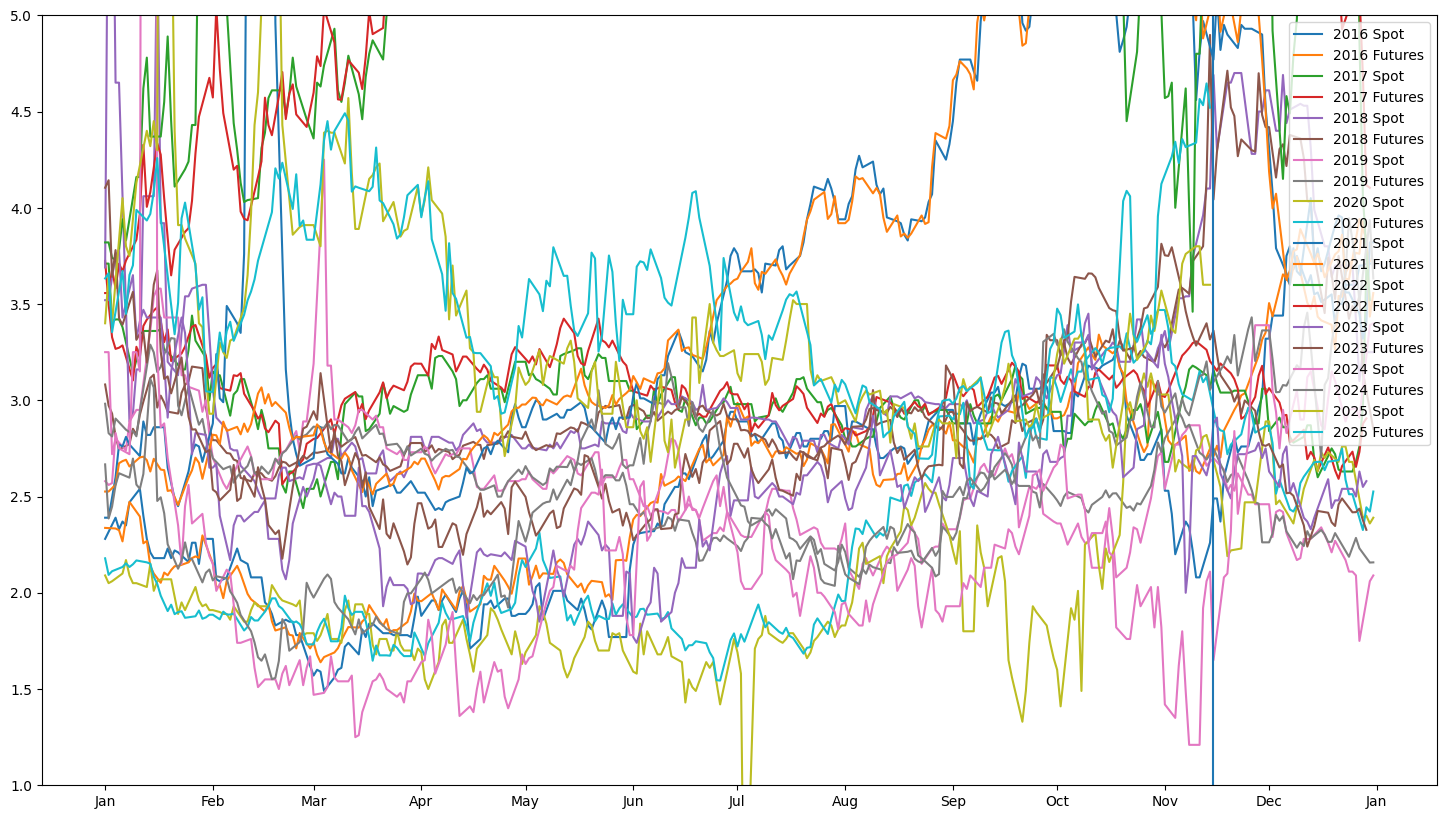

In [24]:
import matplotlib.dates as mdates

plt.figure(figsize=(18, 10))
for key in grouped_price_df.groups.keys():
    if key > 2015:
        md_prices = get_prices_for_year(grouped_price_df, 'Henry Hub Natural Gas Spot Price, Daily', key)
        # md_prices = md_prices / md_prices.iloc[0]
        futures_prices = get_prices_for_year(grouped_price_df, 'Futures Price', key)
        # futures_prices = futures_prices / futures_prices.iloc[0]
        # plt.plot(grouped_price_df.get_group(key).index.to_series().apply(lambda s: datetime.date(1, s.month, s.day)), grouped_price_df.get_group(key))
        plt.plot(md_prices, label=f'{key} Spot')
        plt.plot(futures_prices, label=f'{key} Futures')
# plt.xlim(datetime.datetime(2000, 11, 1), datetime.datetime(2000, 11, 30))
plt.ylim(1, 5)
plt.axvline(datetime.datetime(2000, now_datetime.month, now_datetime.day))
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.show()

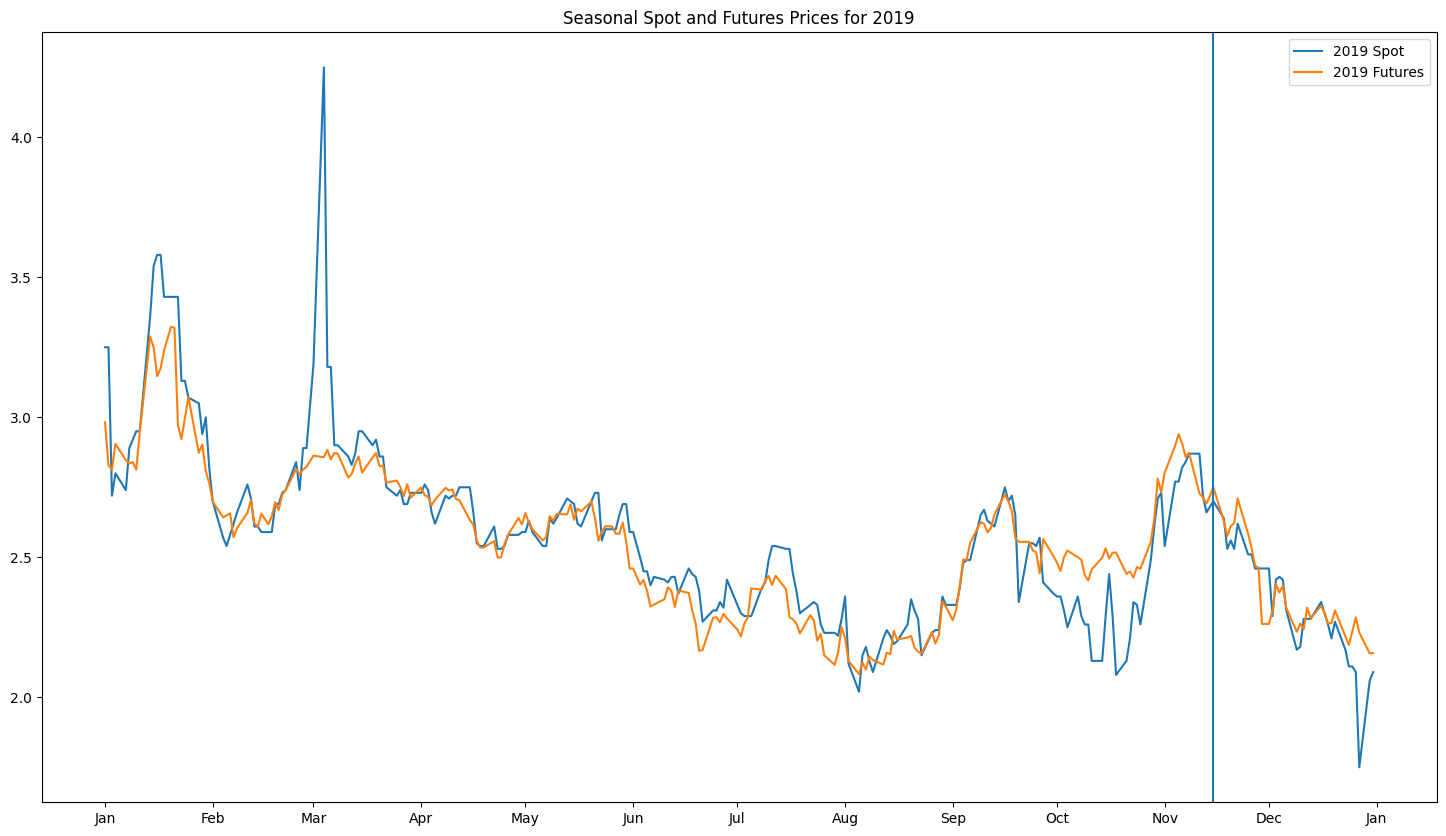

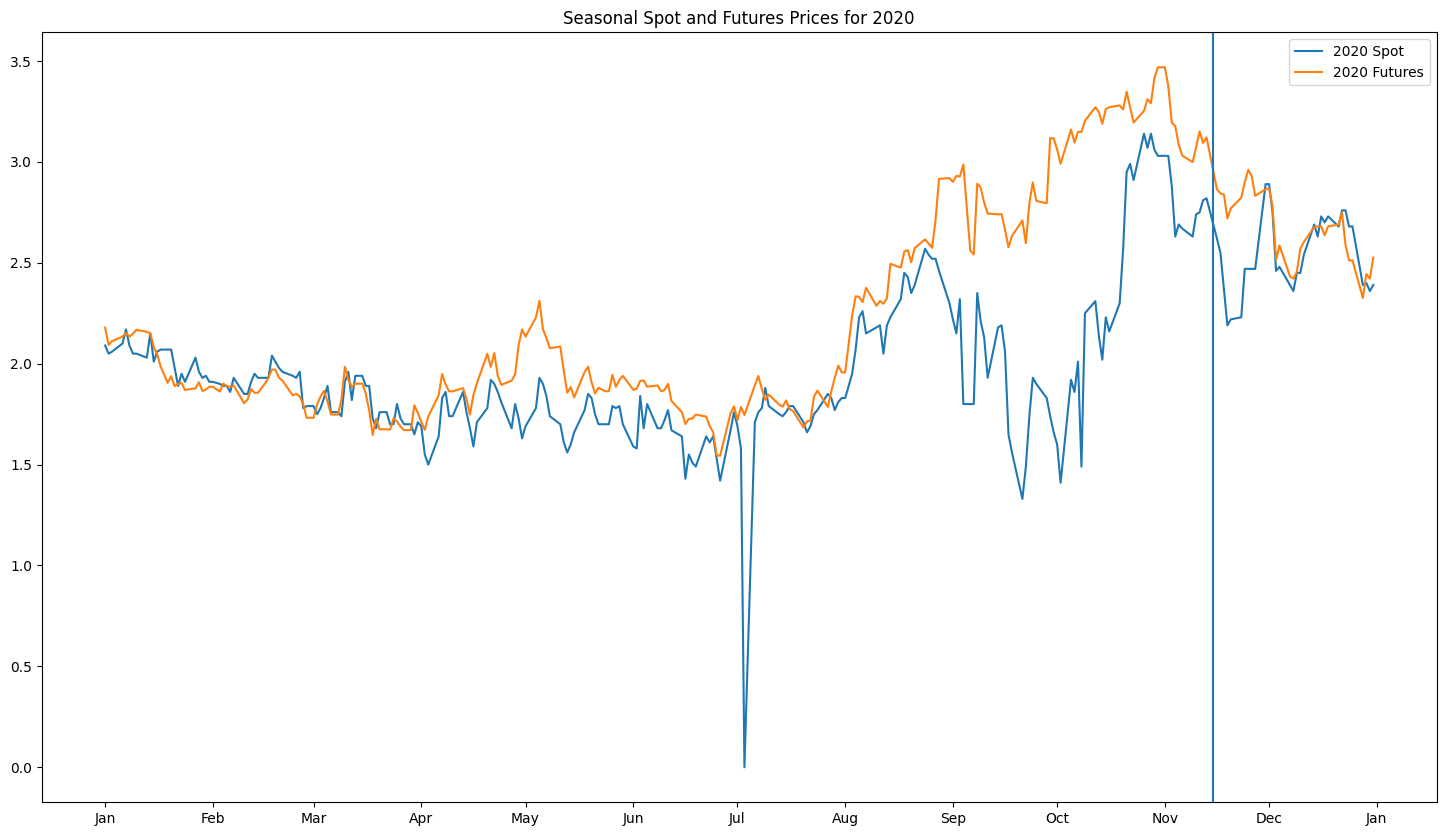

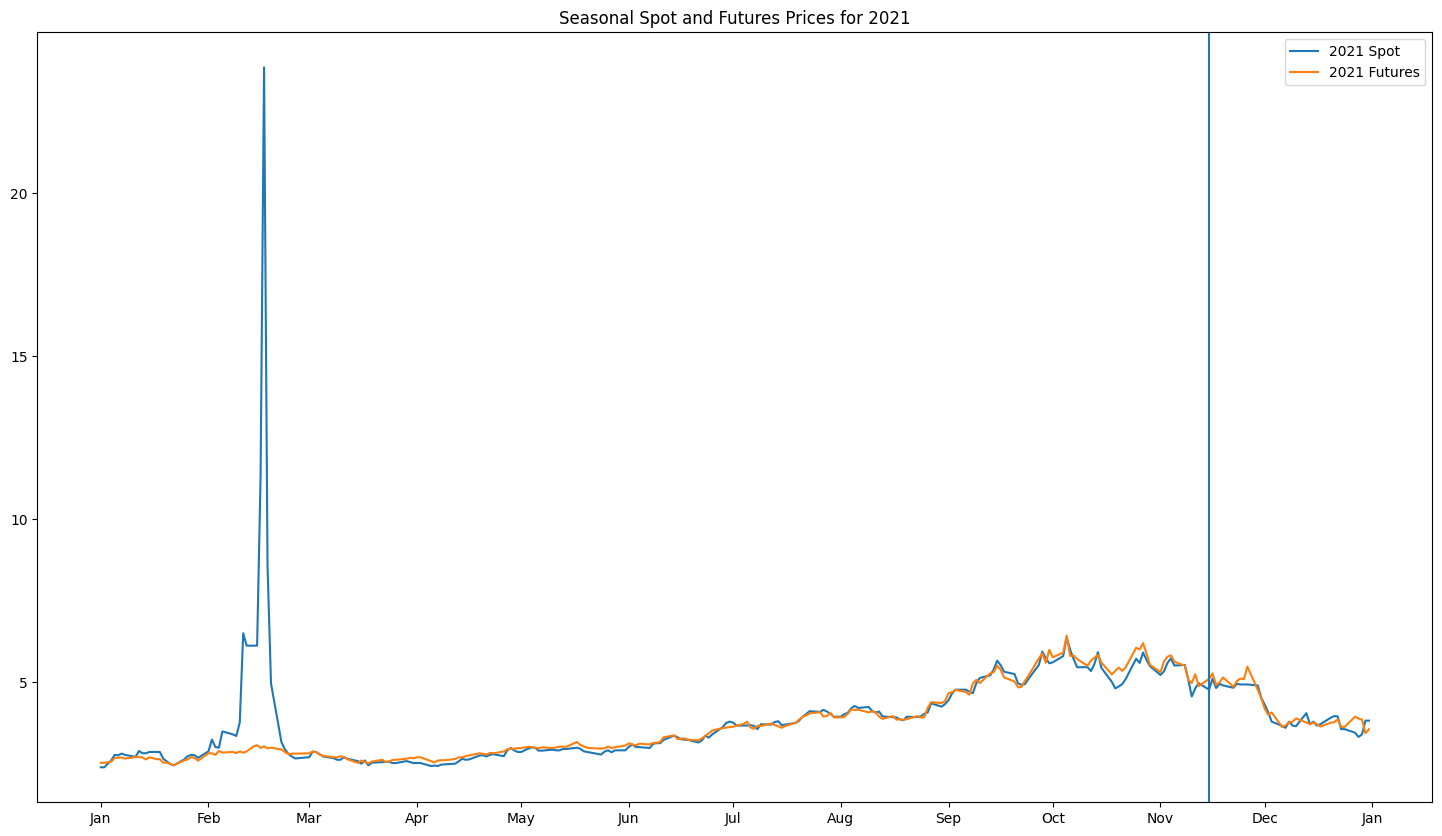

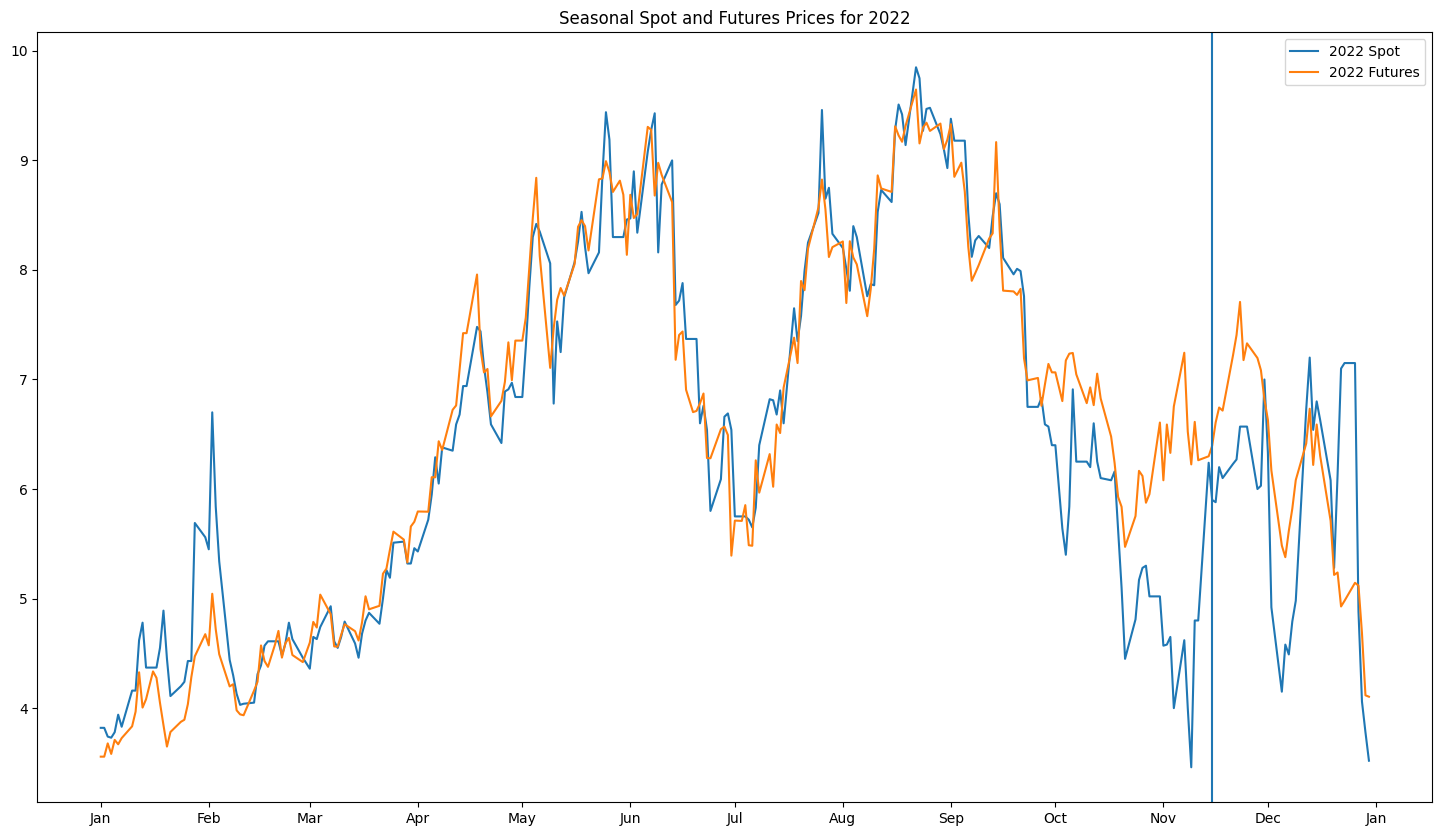

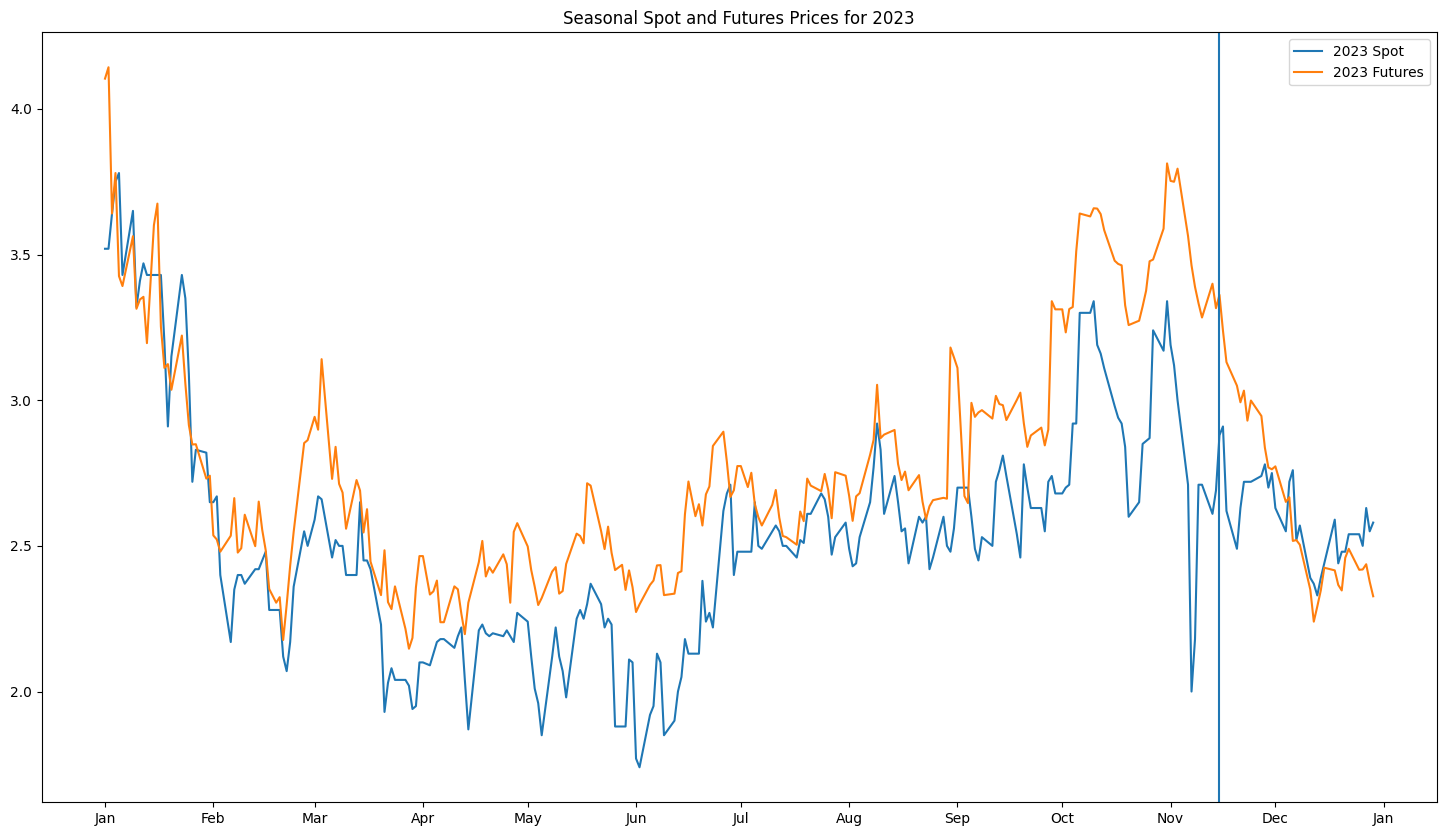

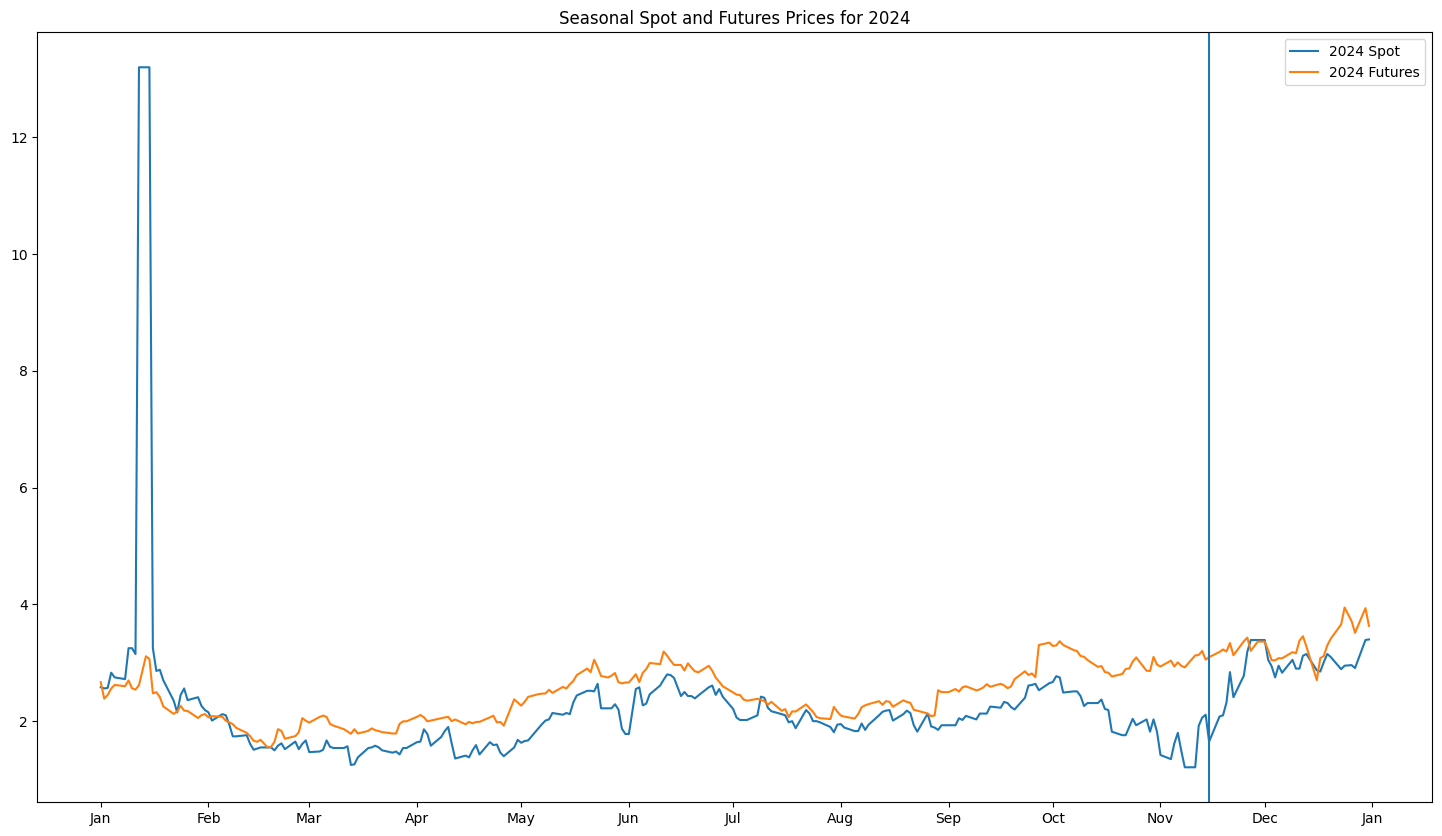

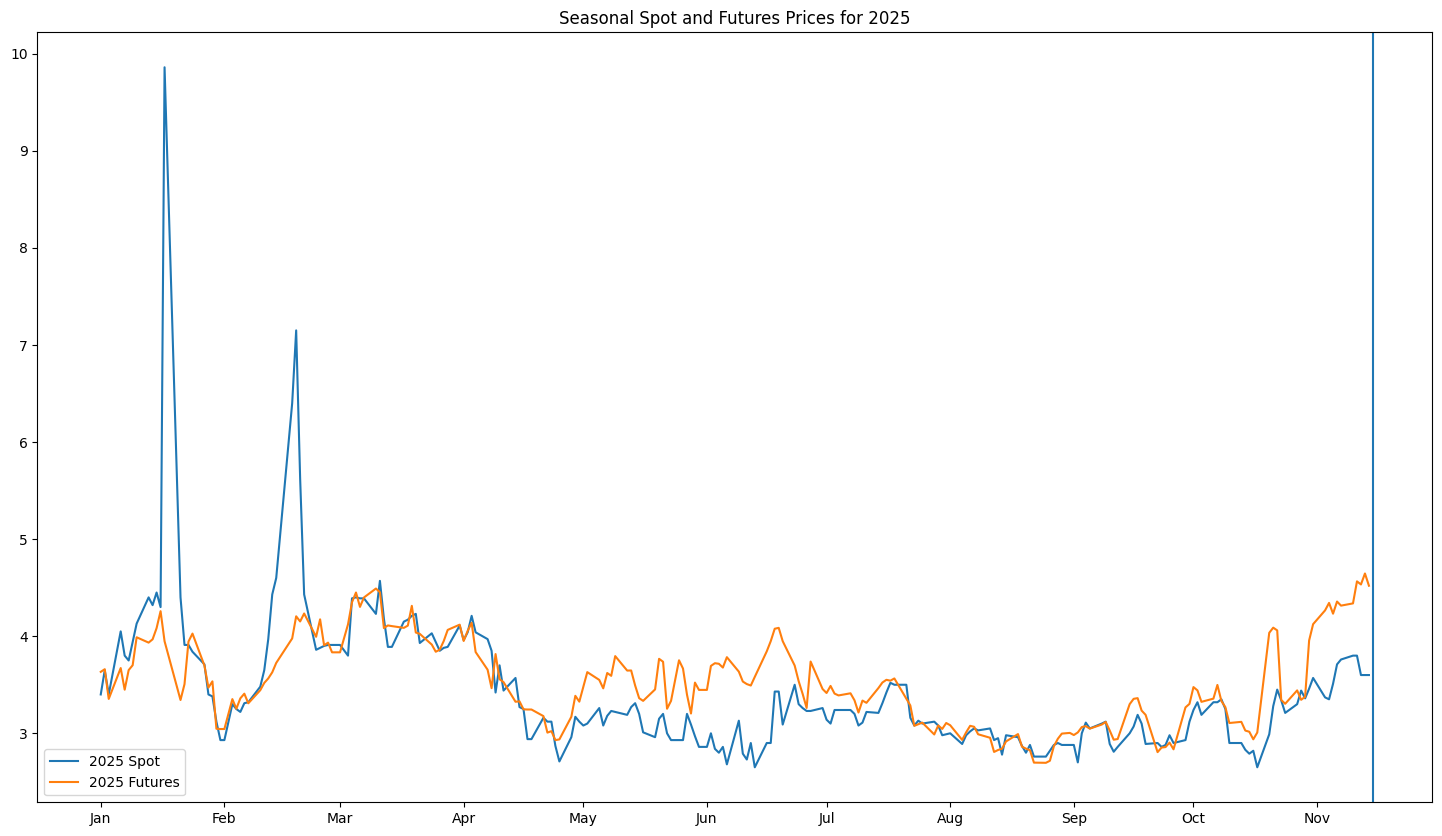

In [25]:
for key in grouped_price_df.groups.keys():
    if key > 2018:
        plt.figure(figsize=(18, 10))
        md_prices = get_prices_for_year(grouped_price_df, 'Henry Hub Natural Gas Spot Price, Daily', key)
        futures_prices = get_prices_for_year(grouped_price_df, 'Futures Price', key)
        plt.plot(md_prices, label=f'{key} Spot')
        plt.plot(futures_prices, label=f'{key} Futures')
        plt.title(f'Seasonal Spot and Futures Prices for {key}')
        plt.axvline(datetime.datetime(2000, now_datetime.month, now_datetime.day))
        plt.legend()
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
        plt.show()

# October - December seasonality

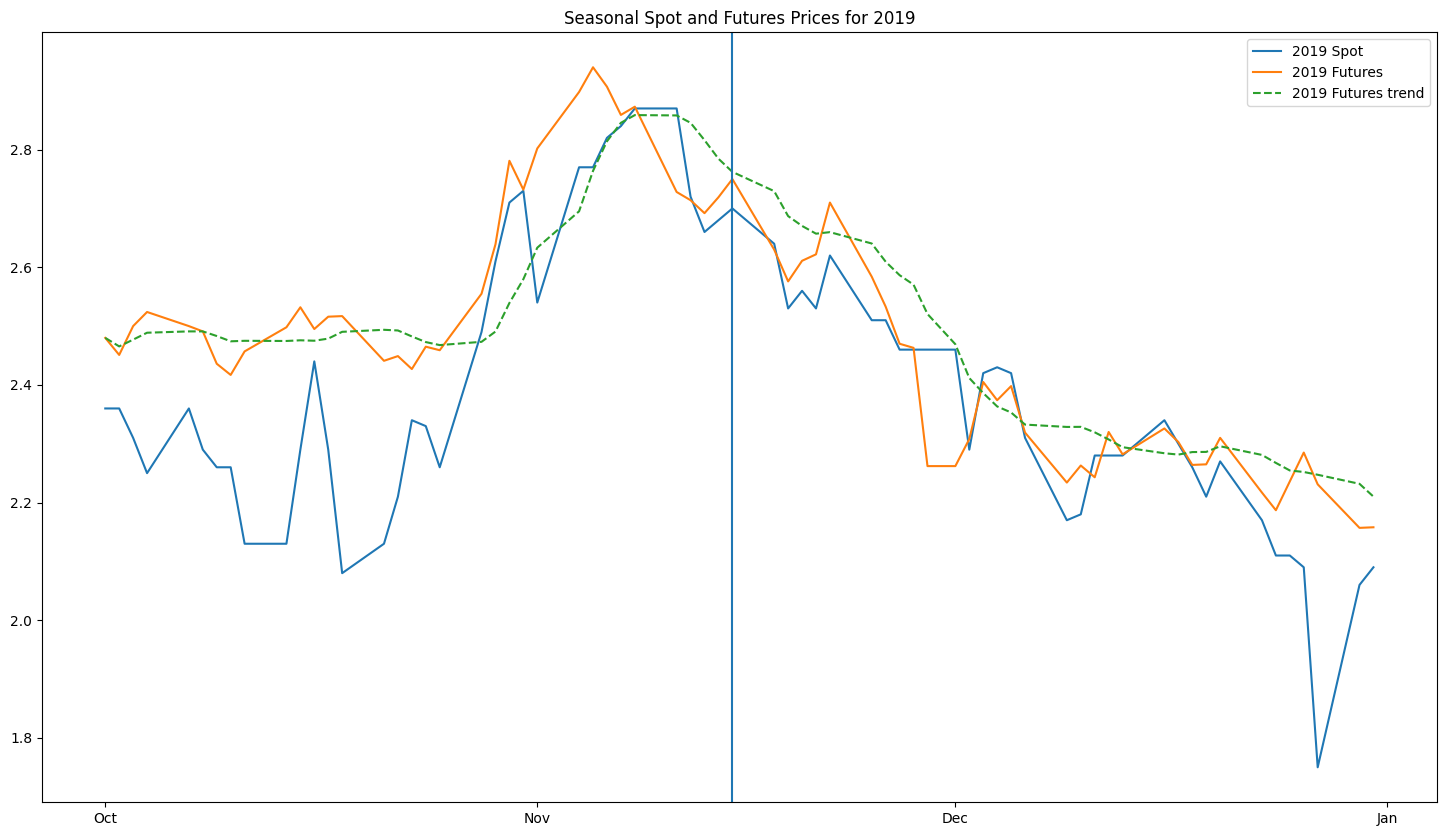

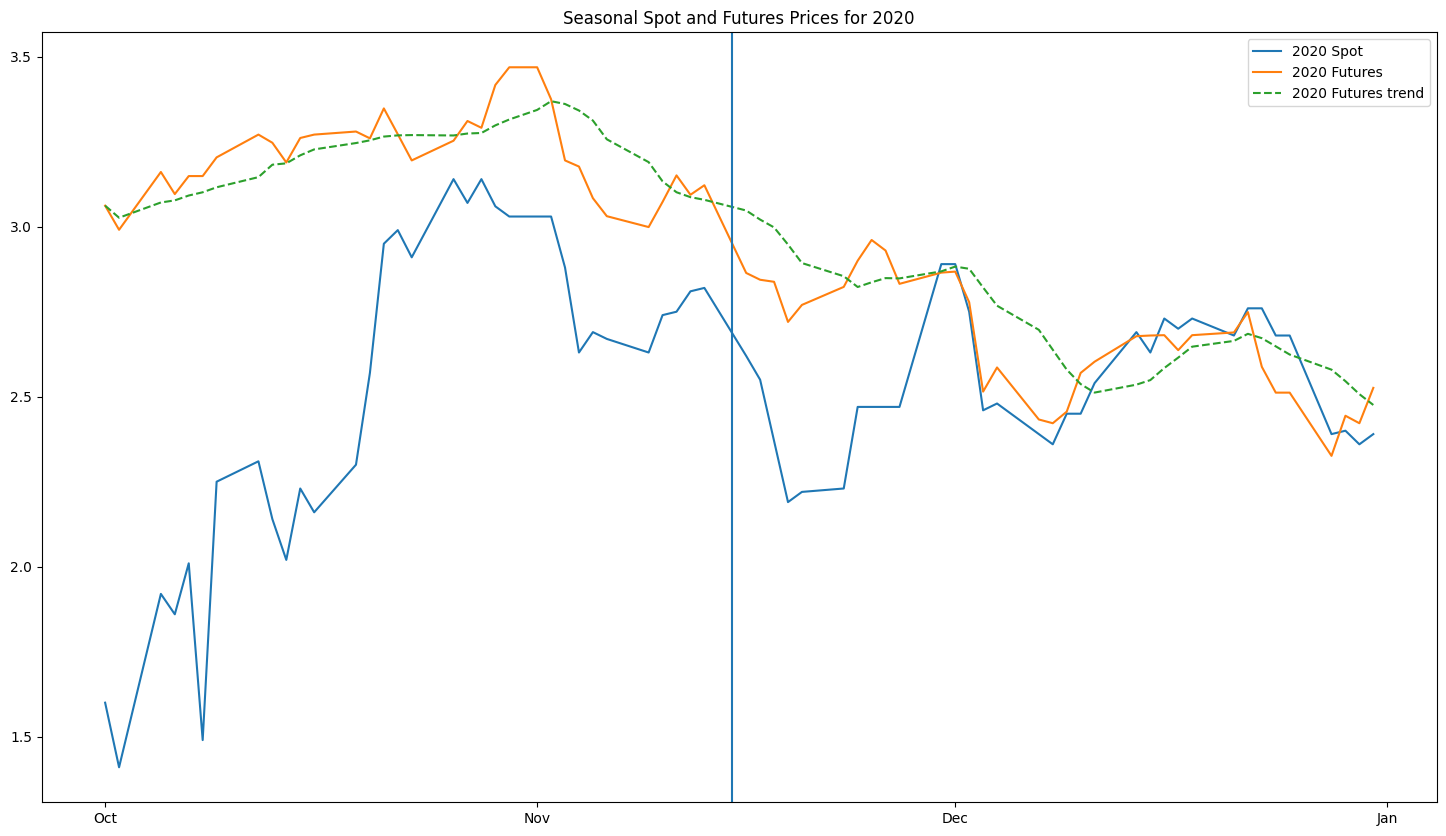

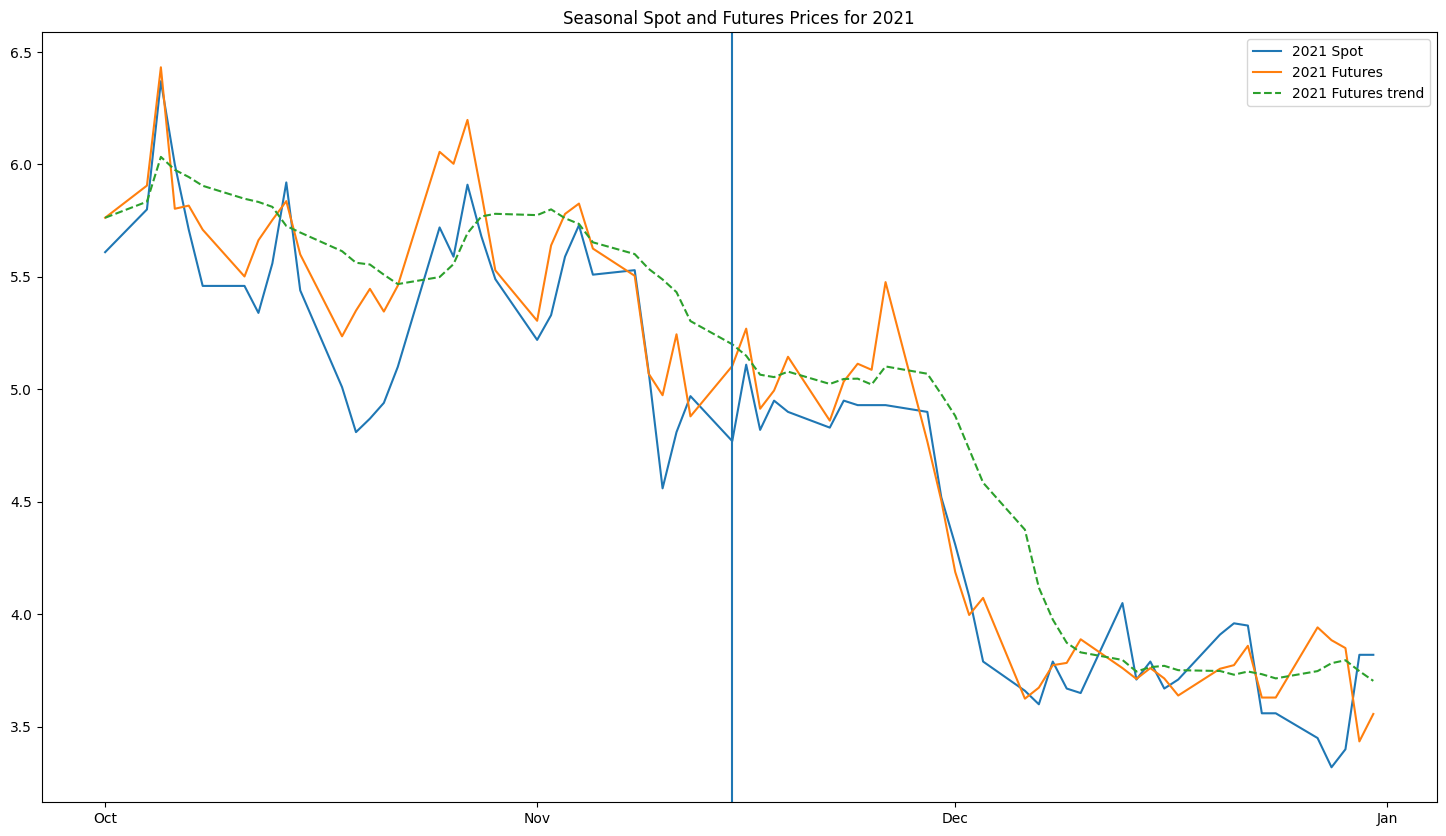

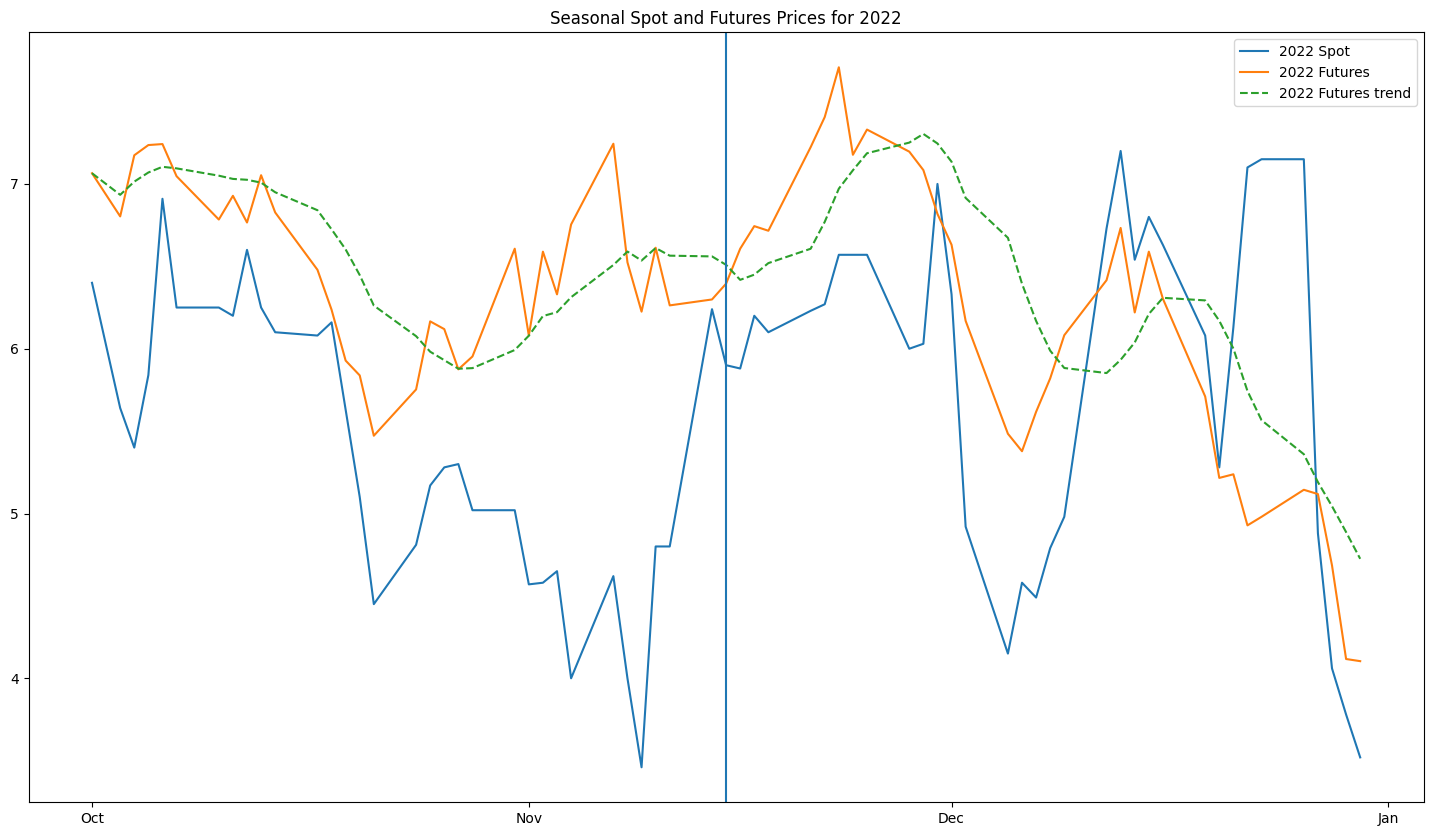

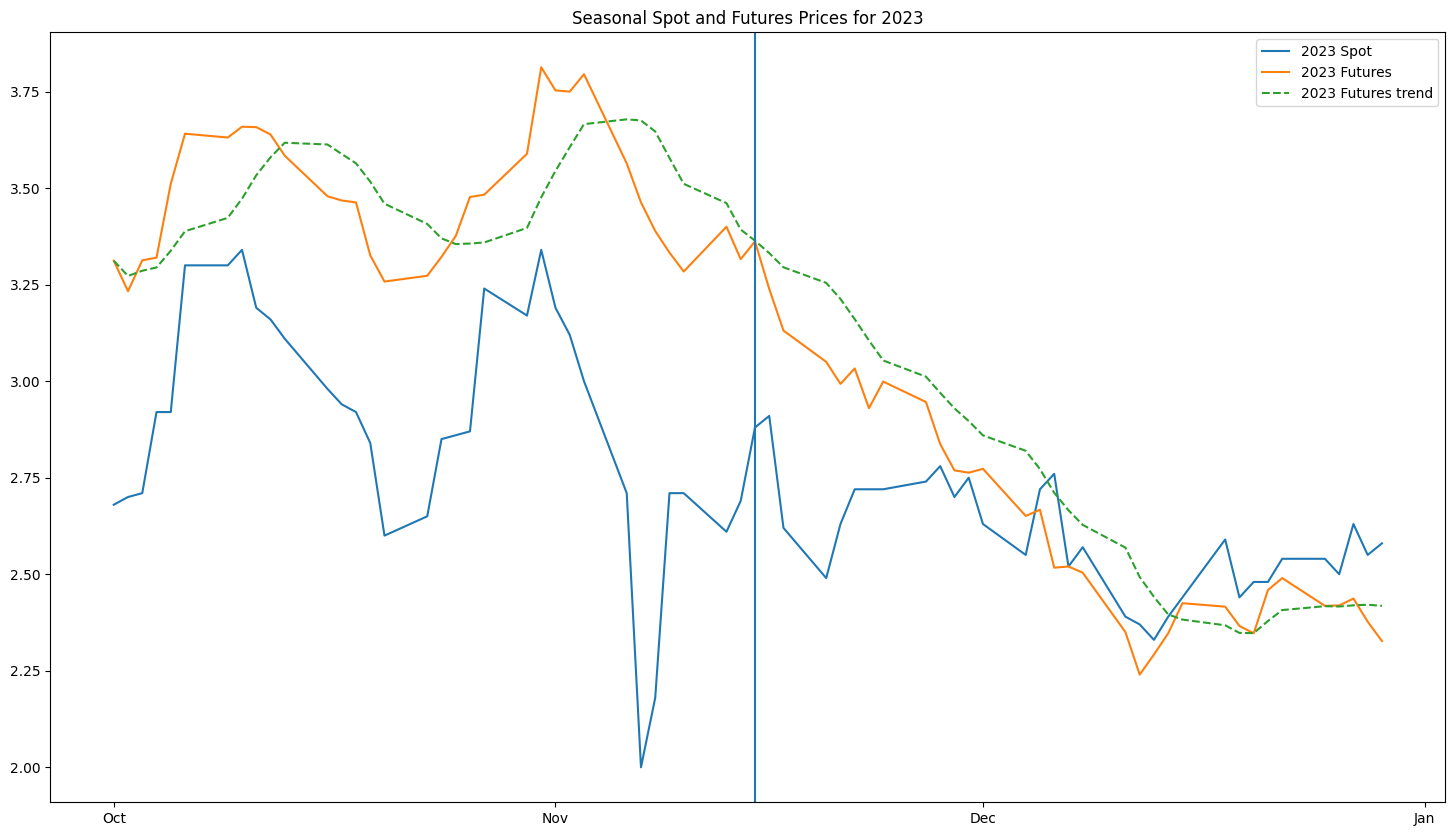

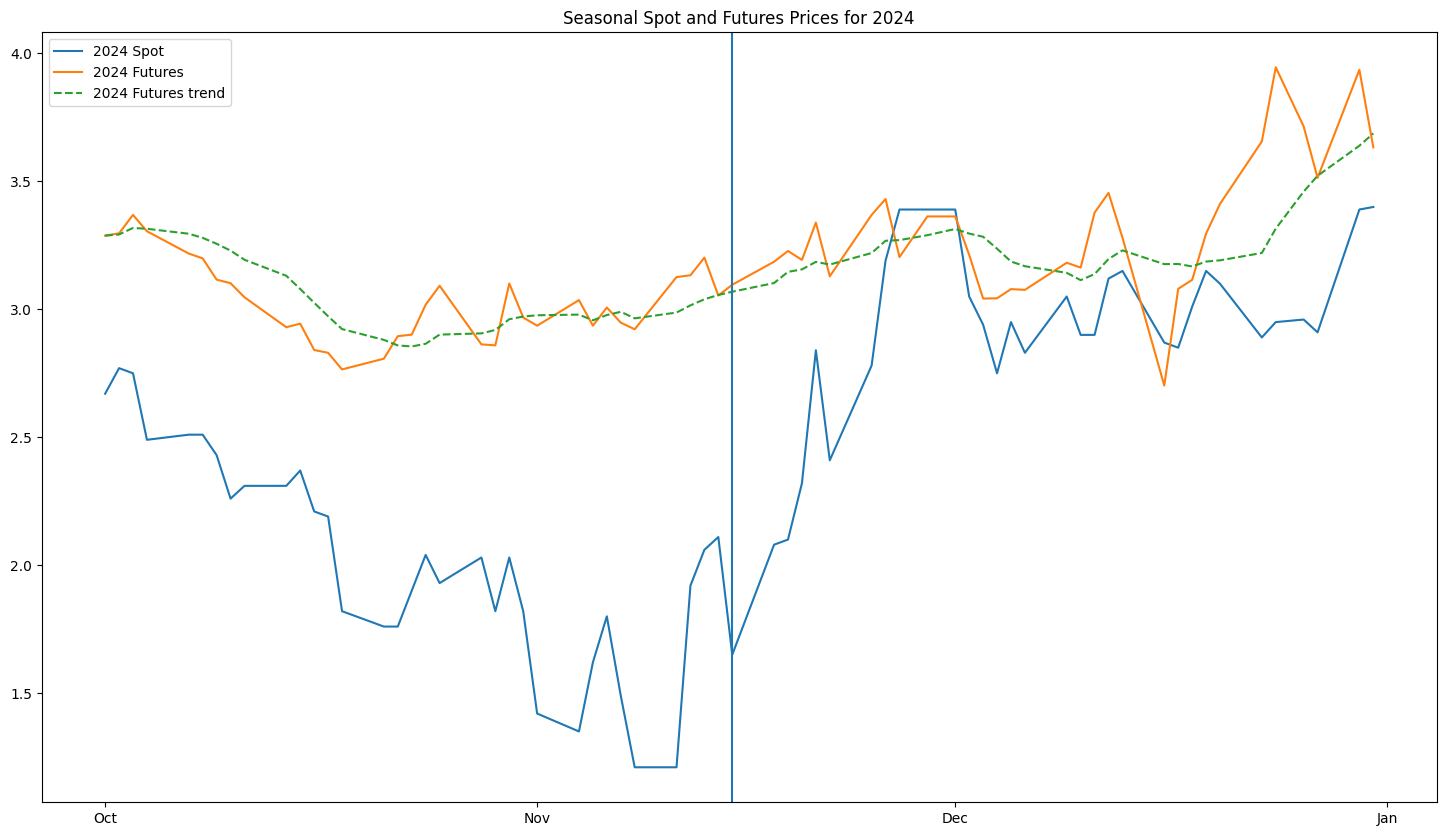

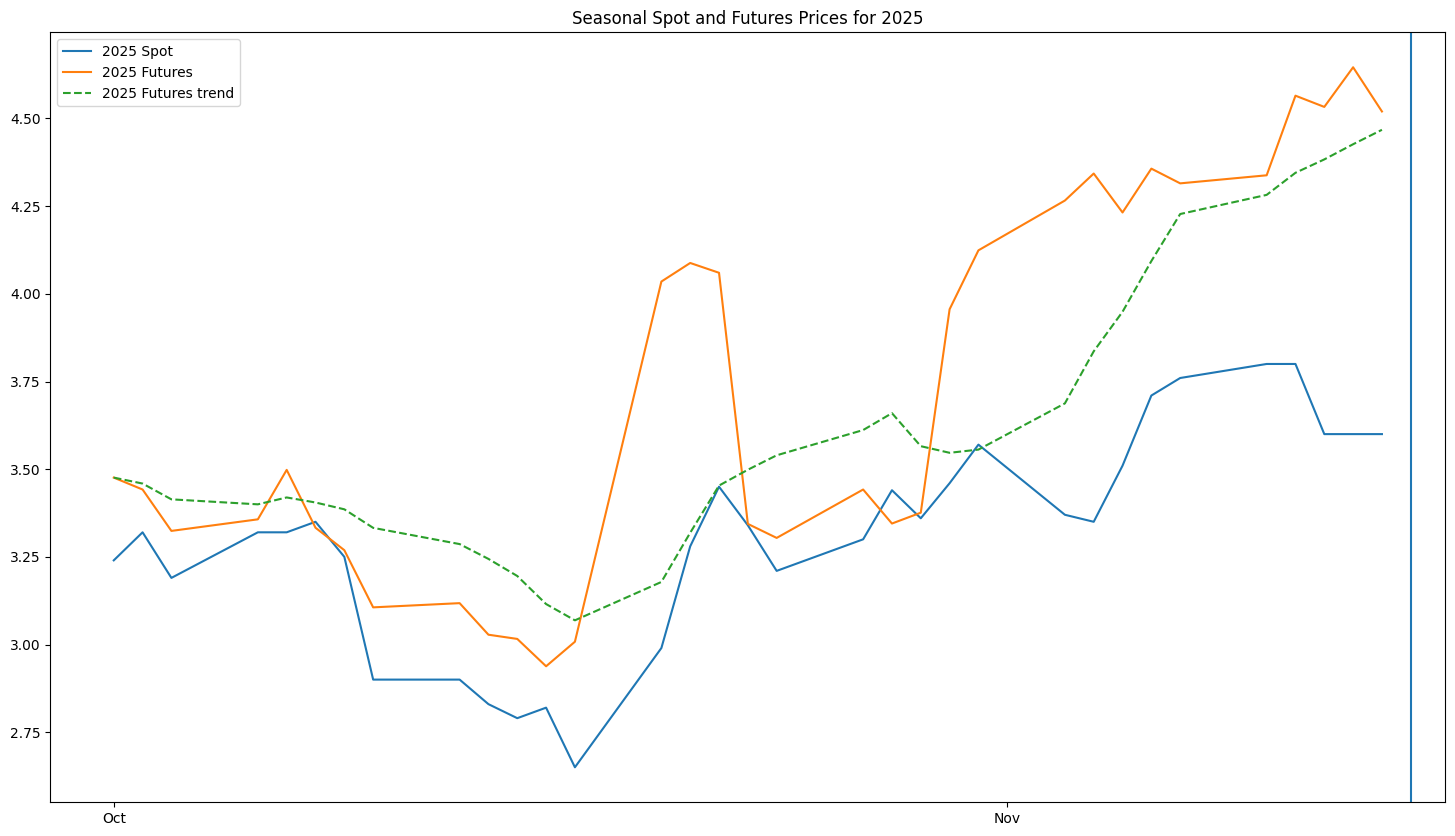

In [26]:
for key in grouped_price_df.groups.keys():
    if key > 2018:
        plt.figure(figsize=(18, 10))
        md_prices = get_prices_for_year(grouped_price_df, 'Henry Hub Natural Gas Spot Price, Daily', key).loc["2000-10-01":"2000-12-31"]
        futures_prices = get_prices_for_year(grouped_price_df, 'Futures Price', key).loc["2000-10-01":"2000-12-31"]
        plt.plot(md_prices, label=f'{key} Spot')
        plt.plot(futures_prices, label=f'{key} Futures')
        
        # trend line for futures
        y = futures_prices.values.astype(float)
        x = np.arange(len(y))  # 0,1,2,... – wystarczy do regresji

        mask = ~np.isnan(y)
        x_fit = x[mask]
        y_fit = y[mask]

        # y = a*x + b
        a, b = np.polyfit(x_fit, y_fit, 1)
        trend = futures_prices.rolling(7, min_periods=1).mean()

        plt.plot(
            futures_prices.index,
            trend,
            '--',
            label=f'{key} Futures trend'
        )
        
        plt.title(f'Seasonal Spot and Futures Prices for {key}')
        plt.axvline(datetime.datetime(2000, now_datetime.month, now_datetime.day))
        plt.legend()
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
        plt.show()

In [27]:
all_years = []
years = []
for key in grouped_price_df.groups.keys():
    if key > 2015:
        md_prices = get_prices_for_year(grouped_price_df, 'Futures Price', key)
        md_prices = md_prices / md_prices.iloc[0]
        all_years.append(md_prices)
        # years.append(key)

all_years_df = pd.concat(all_years, axis=1)

In [28]:
# Sanity check
all_years_df.head()

,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
2000-01-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2000-01-02,NaN,0.939850,0.964633,0.948692,0.960532,1.000000,1.000000,1.009503,0.894638,1.007432
2000-01-03,NaN,0.893394,0.951006,0.942991,0.969252,NaN,1.034017,0.887183,0.917885,0.923204
2000-01-04,0.998716,0.877282,0.912719,0.974178,NaN,1.013856,1.007028,0.921053,0.959505,NaN
2000-01-05,0.994865,0.878894,0.890655,NaN,NaN,1.058195,1.043014,0.834795,0.982752,NaN


Plotting min, mean and max prices through year with normalized prices

<Figure size 1500x1000 with 0 Axes>

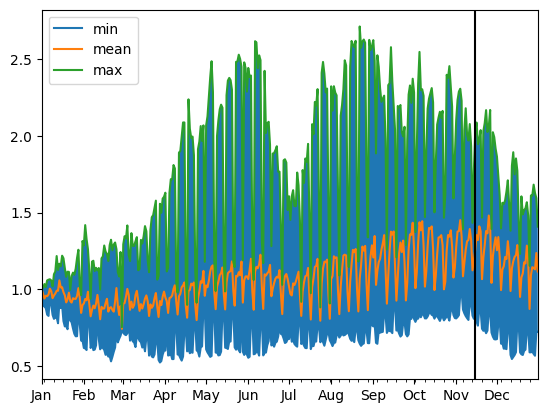

In [29]:
all_years_df['mean'] = all_years_df.mean(axis=1, skipna=True)
all_years_df['min'] = all_years_df.min(axis=1, skipna=True)
all_years_df['max'] = all_years_df.max(axis=1, skipna=True)
all_years_df.sort_index()

plt.figure(figsize=(15, 10))
all_years_df.plot(y=["min", "mean", "max"], kind="line")
plt.fill_between(all_years_df.index, all_years_df["min"], all_years_df["max"])
# plt.ylim(0, 3)
plt.axvline(datetime.datetime(2000, now_datetime.month, now_datetime.day), color='black')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.show()

Plotting the same without normalization

<Figure size 1500x1000 with 0 Axes>

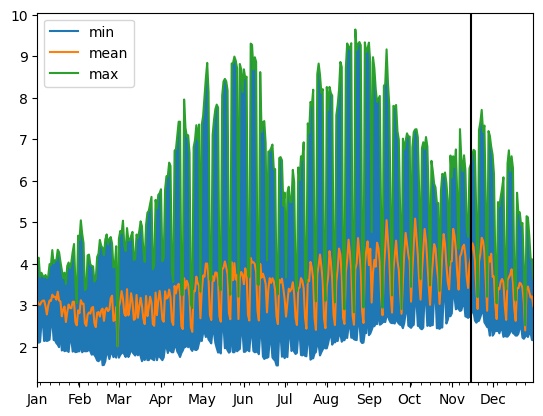

In [30]:
all_years = []
years = []
for key in grouped_price_df.groups.keys():
    if key > 2018:
        md_prices = get_prices_for_year(grouped_price_df, 'Futures Price', key)
        md_prices = md_prices
        all_years.append(md_prices)
        # years.append(key)

all_years_df = pd.concat(all_years, axis=1)

all_years_df['mean'] = all_years_df.mean(axis=1, skipna=True)
all_years_df['min'] = all_years_df.min(axis=1, skipna=True)
all_years_df['max'] = all_years_df.max(axis=1, skipna=True)
all_years_df.sort_index()

plt.figure(figsize=(15, 10))
all_years_df.plot(y=["min", "mean", "max"], kind="line")
plt.fill_between(all_years_df.index, all_years_df["min"], all_years_df["max"])
plt.axvline(datetime.datetime(2000, now_datetime.month, now_datetime.day), color='black')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.show()

This doesn't give too much insight. Let's see the weekly fluctuation in price - if mean on specific day can be higher or lower

In [32]:
all_data_df.columns

Index(['Weekly Lower 48 States Natural Gas Working Underground Storage, Weekly',
       'Weekly Pacific Region Natural Gas Working Underground Storage, Weekly',
       'Weekly Mountain Region Natural Gas Working Underground Storage, Weekly',
       'Weekly South Central  Region Natural Gas Working Underground Storage, Weekly',
       'Weekly Midwest Region Natural Gas Working Underground Storage, Weekly',
       'Weekly Nonsalt Region Natural Gas Working Underground Storage, Weekly',
       'Weekly Salt Region Natural Gas Working Underground Storage, Weekly',
       'Weekly East Region Natural Gas Working Underground Storage, Weekly',
       'Henry Hub Natural Gas Spot Price, Weekly',
       'Henry Hub Natural Gas Spot Price, Daily',
       ...
       'Louisiana Natural Gas Net International Receipts From Yemen, Annual',
       'Louisiana Natural Gas Net International Receipts From Peru, Annual',
       'Mississippi Natural Gas International Receipts from Egypt, Annual',
       'Missis

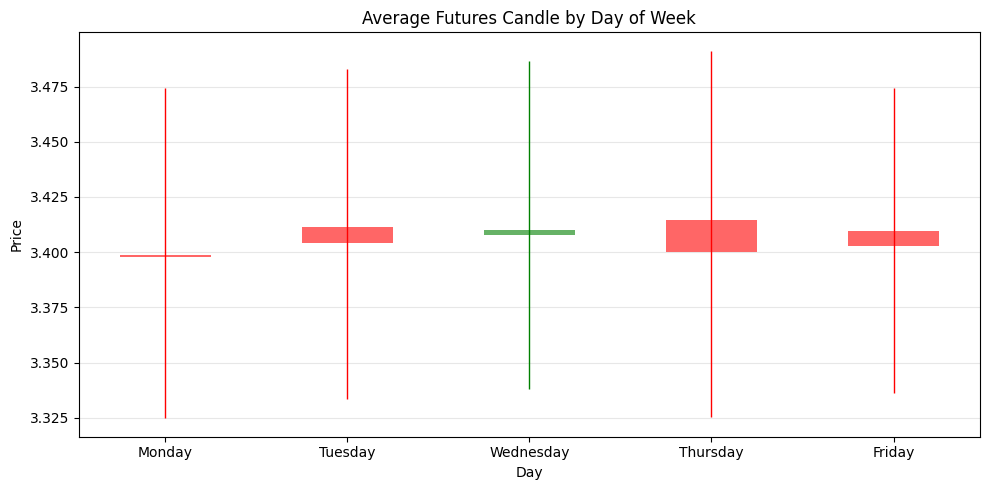

In [33]:
# prepare data
weekday_df = all_data_df[['Futures Price', 'Futures High', 'Futures Low', 'Futures Open']].copy()
weekday_df['weekday'] = weekday_df.index.day_name()

# aggregate OHLC by weekday
stats = (
    weekday_df
    .groupby('weekday')[['Futures Open', 'Futures High', 'Futures Low', 'Futures Price']]
    .mean()
    .rename(columns={'Futures Price': 'Futures Close'})
)

# reorder
order = ['Monday','Tuesday','Wednesday','Thursday','Friday']
stats = stats.loc[order]

# plotting "average candles"
x = np.arange(len(stats))

plt.figure(figsize=(10, 5))

for i, day in enumerate(stats.index):
    o = stats.loc[day, 'Futures Open']
    h = stats.loc[day, 'Futures High']
    l = stats.loc[day, 'Futures Low']
    c = stats.loc[day, 'Futures Close']

    color = 'g' if c >= o else 'r'

    # wick
    plt.vlines(i, l, h, linewidth=1, color=color)
    # body
    plt.bar(i, c - o, bottom=o, width=0.5, color=color, alpha=0.6, align='center')

plt.xticks(x, stats.index)
plt.title('Average Futures Candle by Day of Week')
plt.xlabel('Day')
plt.ylabel('Price')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()